In [1]:
import cv2
import glob
import scipy.io
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup
import requests

In [2]:
# Scrape information from AKC website
page = requests.get('https://www.akc.org/dog-breeds/sporting/page/3')
soup = BeautifulSoup(page.content,'html.parser')
name_links = soup.select_one('select."custom-select__select"').select('option')[1:]
group_map = {}
for p in name_links:
    link = p.get('value')
    l_soup = BeautifulSoup(requests.get(link).content,'html.parser')
    group_map[p.text.lower()]=l_soup.select_one('li > span > a').text

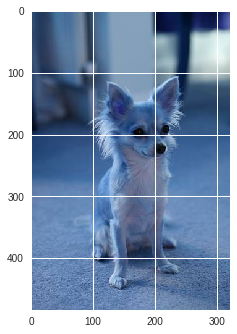

In [3]:
im=cv2.imread('Images/n02085620-Chihuahua/n02085620_10976.jpg')
plt.imshow(im)
plt.show()

In [4]:
def resize(im,desired_size=250):
    old_size = im.shape[:2] 
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    plt.imshow(new_im)
    plt.show()

In [5]:
def resize2(im,desired_size=250):
    old_size = im.shape[:2] 
    ratio = float(desired_size)/min(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im2 = cv2.resize(im, (new_size[1], new_size[0]))
    if im2.shape[0]>250:
        mid=int(im2.shape[0]/2)
        lt=mid-125
        rt=mid+125
        im3=im2[lt:rt,:,:]
    else:
        mid=int(im2.shape[1]/2)
        lt=mid-125
        rt=mid+125
        im3=im2[:,lt:rt,:]
    im4=cv2.resize(im3,(250,250))/255
    return im4

In [6]:
file_type=pd.read_csv('file',header=None,names=['filename','type'])
file_type['breed']=[i.split('/')[0].split('-')[1] for i in file_type.filename.values]
file_type['breed_class']=[class_dictionary[i] for i in file_type.]
file_type.head()

In [43]:
# key is breed name and value is list containing the 10 images
breeds_10=list()
class_dictionary={}
for i in range(1,121):
    breed=dict()
    breed['breed']=file_type['breed'].loc[file_type.type==i].values[0]
    breed['type_num']=i
    if breed['breed'].lower().replace('_',' ')=='japanese spaniel':
        breed['breed_class']=group_map['cocker spaniel']
    elif breed['breed'].lower().replace('_',' ')=='maltese dog':
        breed['breed_class']=group_map['maltese']
    elif breed['breed'].lower().replace('_',' ')=='blenheim spaniel':
        breed['breed_class']=group_map['cocker spaniel']
    elif breed['breed'].lower().replace('_',' ')=='pekinese':
        breed['breed_class']=group_map['pekingese']
    elif breed['breed'].lower().replace('_',' ')=='toy terrier':
        breed['breed_class']=group_map['toy fox terrier']
    elif breed['breed'].lower().replace('_',' ')=='walker hound':
        breed['breed_class']=group_map['bluetick coonhound']
    elif breed['breed'].lower().replace('_',' ')=='staffordshire bullterrier':
        breed['breed_class']=group_map['staffordshire bull terrier']
    elif breed['breed'].lower().replace('_',' ')=='boston bull':
        breed['breed_class']=group_map['boston terrier']
    elif breed['breed'].lower().replace('_',' ')=='german short':
        breed['breed_class']=group_map['german shorthaired pointer']
        
    elif breed['breed'].lower().replace('_',' ')=='bull mastiff':
        breed['breed_class']=group_map['bullmastiff']
    elif breed['breed'].lower().replace('_',' ')=='brabancon griffon':
        breed['breed_class']=group_map['brussels griffon']
    elif breed['breed'].lower().replace('_',' ')=='brittany spaniel':
        breed['breed_class']=group_map['brittany']
    elif breed['breed'].lower().replace('_',' ')=='groenendael':
        breed['breed_class']=group_map['old english sheepdog']
    elif 'terrier' in breed['breed'].lower().replace('_',' '):
        breed['breed_class']=group_map['staffordshire bull terrier']
    elif breed['breed']=='toy_poodle':
        breed['breed_class']='Toy Group'
    elif breed['breed']=='Mexican_hairless':
        breed['breed_class']='Non-Sporting Group'
    elif breed['breed']=='miniature_poodle' or breed['breed']=='standard_poodle':
        breed['breed_class']=group_map['poodle (miniature / standard)']
    elif breed['breed']=='dingo':
        breed['breed_class']='Foundation Stock Service'
    elif breed['breed']=='dhole':
        breed['breed_class']='Foundation Stock Service'
    elif breed['breed']=='African_hunting_dog':
        breed['breed_class']='Hound Group'
    elif breed['breed'].lower().replace('_',' ') not in group_map.keys():
        for b in group_map.keys():
            if breed['breed'].lower().replace('_',' ') in b:
                breed['breed_class']=group_map[b]
                break
    else: 
        breed['breed_class']=group_map[breed['breed'].lower().replace('_',' ')]
    images=np.zeros([250,250,3,10])
    print(file_type['breed'].loc[file_type.type==i].values[0])
    class_dictionary[file_type['breed'].loc[file_type.type==i].values[0]]=breed['breed_class']
    for index, row in file_type.loc[file_type.type==i].iterrows():
        if index>9: 
            break
        else: 
            images[:,:,:,index] = resize2(cv2.imread('Images/'+row['filename']))
    breed['images']=images
    breeds_10.append(breed)

Chihuahua
Japanese_spaniel
Maltese_dog
Pekinese
Shih
Blenheim_spaniel
papillon
toy_terrier
Rhodesian_ridgeback
Afghan_hound
basset
beagle
bloodhound
bluetick
black
Walker_hound
English_foxhound
redbone
borzoi
Irish_wolfhound
Italian_greyhound
whippet
Ibizan_hound
Norwegian_elkhound
otterhound
Saluki
Scottish_deerhound
Weimaraner
Staffordshire_bullterrier
American_Staffordshire_terrier
Bedlington_terrier
Border_terrier
Kerry_blue_terrier
Irish_terrier
Norfolk_terrier
Norwich_terrier
Yorkshire_terrier
wire
Lakeland_terrier
Sealyham_terrier
Airedale
cairn
Australian_terrier
Dandie_Dinmont
Boston_bull
miniature_schnauzer
giant_schnauzer
standard_schnauzer
Scotch_terrier
Tibetan_terrier
silky_terrier
soft
West_Highland_white_terrier
Lhasa
flat
curly
golden_retriever
Labrador_retriever
Chesapeake_Bay_retriever
German_short
vizsla
English_setter
Irish_setter
Gordon_setter
Brittany_spaniel
clumber
English_springer
Welsh_springer_spaniel
cocker_spaniel
Sussex_spaniel
Irish_water_spaniel
kuvasz


In [44]:
class_dictionary

{'Afghan_hound': 'Hound Group',
 'African_hunting_dog': 'Hound Group',
 'Airedale': 'Terrier Group',
 'American_Staffordshire_terrier': 'Terrier Group',
 'Appenzeller': 'Foundation Stock Service',
 'Australian_terrier': 'Terrier Group',
 'Bedlington_terrier': 'Terrier Group',
 'Bernese_mountain_dog': 'Working Group',
 'Blenheim_spaniel': 'Sporting Group',
 'Border_collie': 'Herding Group',
 'Border_terrier': 'Terrier Group',
 'Boston_bull': 'Non-Sporting Group',
 'Bouvier_des_Flandres': 'Herding Group',
 'Brabancon_griffon': 'Toy Group',
 'Brittany_spaniel': 'Sporting Group',
 'Cardigan': 'Herding Group',
 'Chesapeake_Bay_retriever': 'Sporting Group',
 'Chihuahua': 'Toy Group',
 'Dandie_Dinmont': 'Terrier Group',
 'Doberman': 'Working Group',
 'English_foxhound': 'Hound Group',
 'English_setter': 'Sporting Group',
 'English_springer': 'Sporting Group',
 'EntleBucher': 'Herding Group',
 'Eskimo_dog': 'Non-Sporting Group',
 'French_bulldog': 'Non-Sporting Group',
 'German_shepherd': 'Her

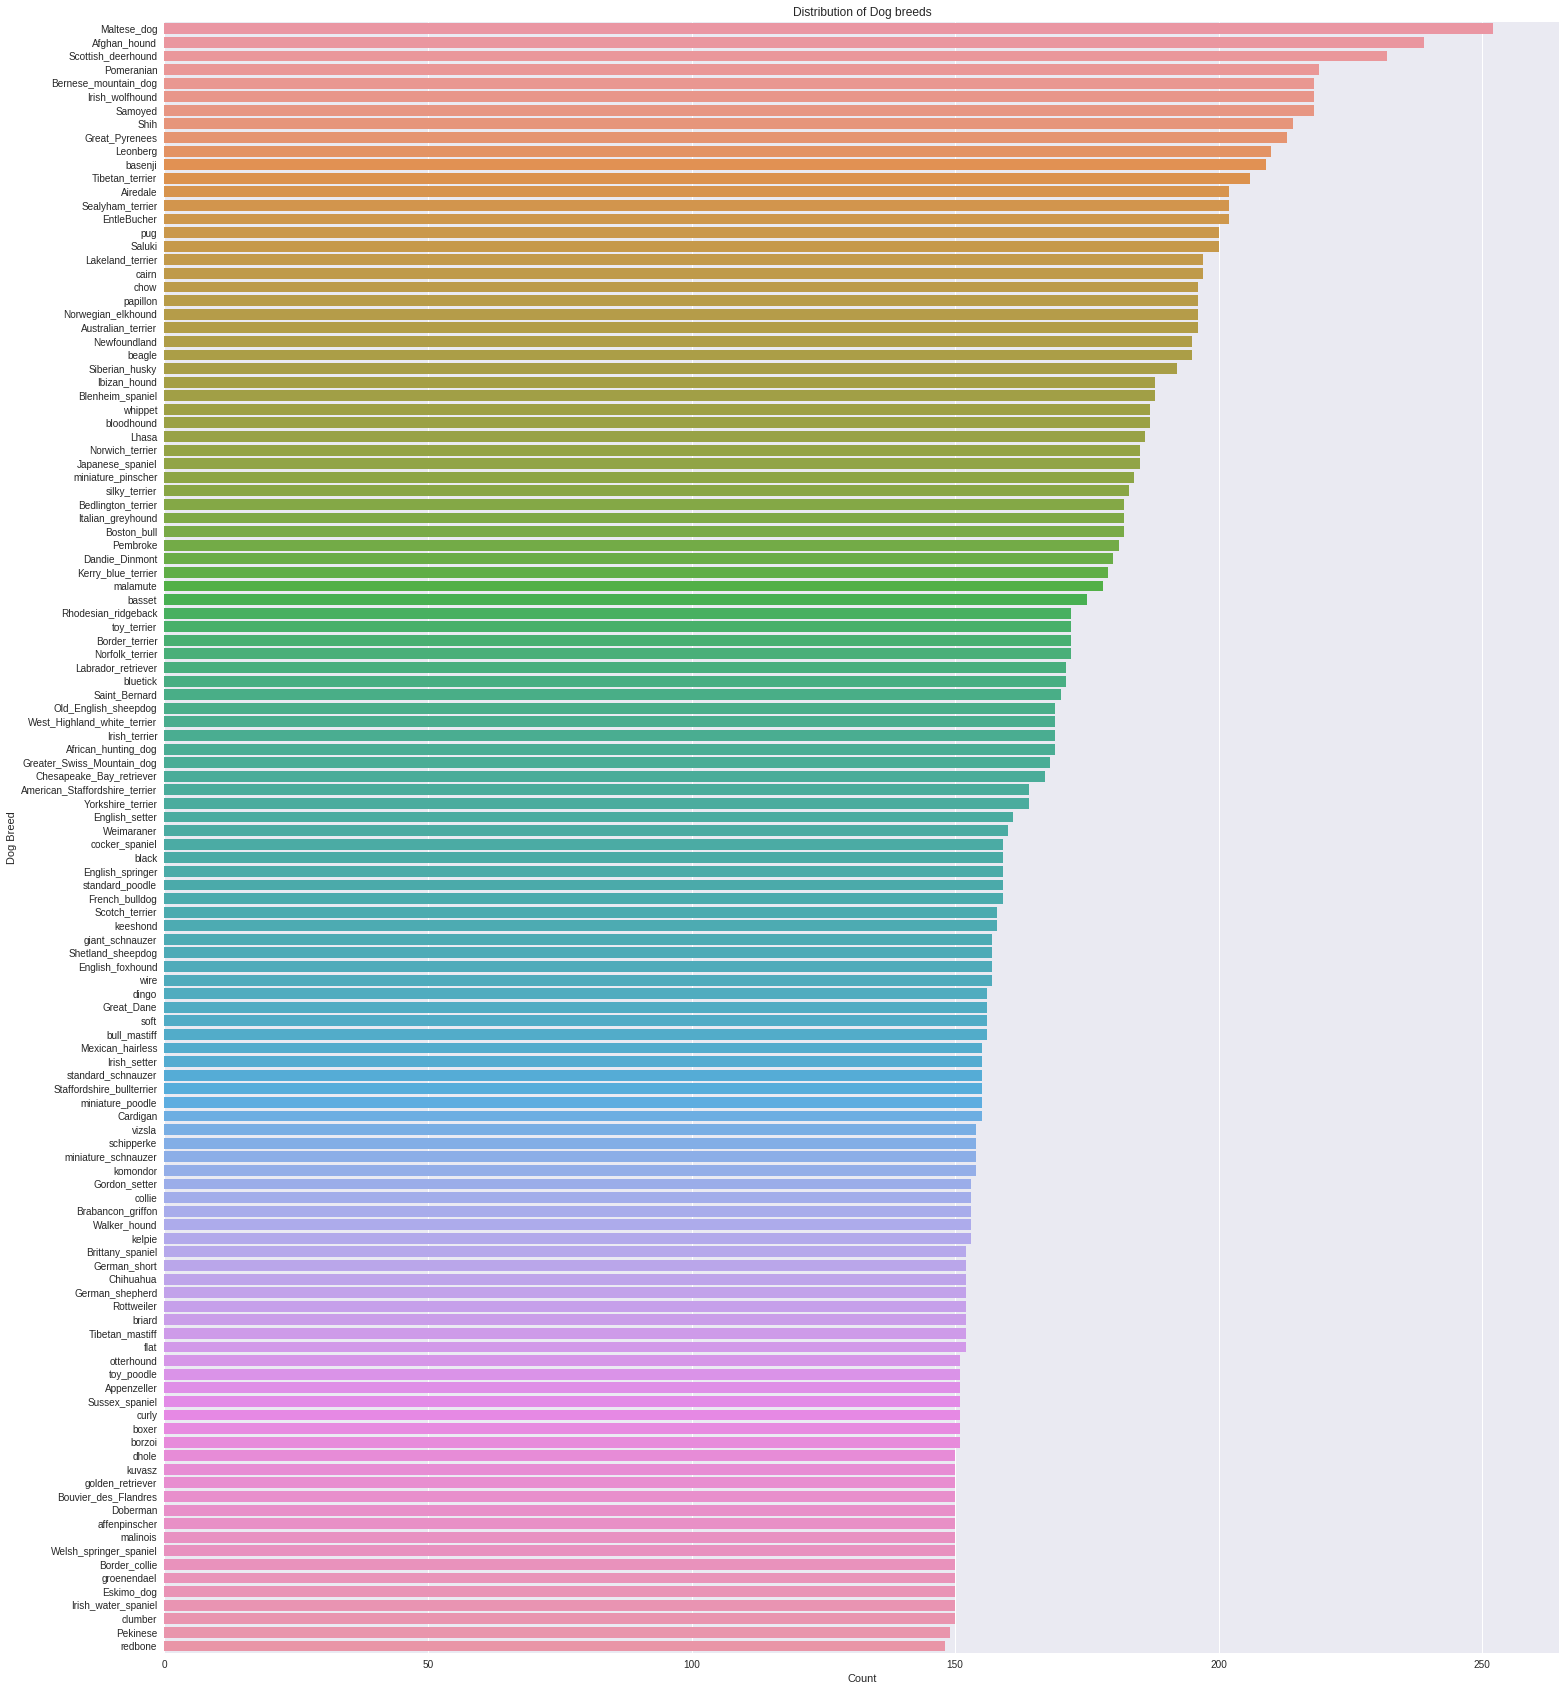

In [9]:
yy=file_type['breed'].value_counts()

fig, ax = plt.subplots()
fig.set_size_inches(25, 30)
sns.set()
ax = sns.barplot(y = yy.index, x = yy, data = file_type,orient='h')
#ax.set_xticklabels(ax.get_yticklabels(), rotation = 90, fontsize = 8)
ax.set(ylabel='Dog Breed', xlabel='Count')
ax.set_title('Distribution of Dog breeds')
plt.savefig('distribution_breeds.png')

In [10]:
yy.head()

Maltese_dog             252
Afghan_hound            239
Scottish_deerhound      232
Pomeranian              219
Bernese_mountain_dog    218
Name: breed, dtype: int64

In [11]:
yy.tail()

Eskimo_dog             150
Irish_water_spaniel    150
clumber                150
Pekinese               149
redbone                148
Name: breed, dtype: int64

In [12]:
group_map

{'affenpinscher': 'Toy Group',
 'afghan hound': 'Hound Group',
 'airedale terrier': 'Terrier Group',
 'akita': 'Working Group',
 'alaskan malamute': 'Working Group',
 'american english coonhound': 'Hound Group',
 'american eskimo dog': 'Non-Sporting Group',
 'american foxhound': 'Hound Group',
 'american hairless terrier': 'Terrier Group',
 'american leopard hound': 'Foundation Stock Service',
 'american staffordshire terrier': 'Terrier Group',
 'american water spaniel': 'Sporting Group',
 'anatolian shepherd dog': 'Working Group',
 'appenzeller sennenhund': 'Foundation Stock Service',
 'australian cattle dog': 'Herding Group',
 'australian kelpie': 'Foundation Stock Service',
 'australian shepherd': 'Herding Group',
 'australian stumpy tail cattle dog': 'Foundation Stock Service',
 'australian terrier': 'Terrier Group',
 'azawakh': 'Miscellaneous Class',
 'barbet': 'Miscellaneous Class',
 'basenji': 'Hound Group',
 'basset fauve de bretagne': 'Foundation Stock Service',
 'basset hound